In [760]:
import sys

In [761]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [762]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/My Drive/schoolwork/3rd_year/winter/cs_m146/hw_1/']
#sys.path.remove('/content/drive/My Drive/schoolwork/3rd_year/winter/cs_m146/hw_1')
#print(sys.path)
### ========== TODO : END ========== ###


In [763]:
from nutil import *

In [764]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [765]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [766]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ### --> DONE
        # part b: set self.probabilities_ according to the training set --> DONE
        
        # count up occurances
        cnt = Counter(y).most_common()

        # map labels to probabilities
        total_instances = y.shape[0]
        self.probabilities_ = {}
        for label, count in cnt:
          self.probabilities_[label] = count/total_instances
      
        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ### --> DONE
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)

        # extract labels, probabilities from dictionary
        labels, probabilities = [], []
        for key, value in self.probabilities_.items():
          labels.append(key)
          probabilities.append(value)

        n,d = X.shape
        y = np.random.choice(labels, n, True, probabilities)

        
        ### ========== TODO : END ========== ###

        return y


In [767]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('/content/drive/My Drive/schoolwork/3rd_year/winter/cs_m146/hw_1/histograms.png')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [768]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use train_test_split (be careful of the parameters)
    
    cumuluative_train_error = cumulative_test_error = cumulative_f1 = 0
    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    
    for train_index, test_index in sss.split(X, y):
      # retrieve data splits
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      
      # fit to training data
      clf.fit(X_train, y_train)

      # evaluate on train set
      y_pred = clf.predict(X_train)
      cumuluative_train_error += 1 - metrics.accuracy_score(y_train, y_pred, normalize=True)

      # evaluate on test set
      y_pred = clf.predict(X_test)
      cumulative_test_error += 1 - metrics.accuracy_score(y_test, y_pred, normalize=True)

      # get F1 score on test set
      cumulative_f1 += metrics.f1_score(y_test, y_pred)

    # average out error metrics
    train_error = cumuluative_train_error/ntrials
    test_error = cumulative_test_error/ntrials
    f1_score = cumulative_f1/ntrials

   
    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score

def error2(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use train_test_split (be careful of the parameters)
    
    cumuluative_train_error = cumulative_test_error = cumulative_f1 = 0
    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    
    for train_index, test_index in sss.split(X, y):
      # retrieve data splits
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      
      # fit to training data
      clf.fit(X_train, y_train)

      # evaluate on train set
      y_pred = clf.predict(X_train)
      cumuluative_train_error += 1 - metrics.accuracy_score(y_train, y_pred, normalize=True)

      # evaluate on test set
      y_pred = clf.predict(X_test)
      cumulative_test_error += 1 - metrics.accuracy_score(y_test, y_pred, normalize=True)

      # get F1 score on test set
      cumulative_f1 += metrics.f1_score(y_test, y_pred)

    # average out error metrics
    train_error = cumuluative_train_error/ntrials
    test_error = cumulative_test_error/ntrials
    f1_score = cumulative_f1/ntrials

   
    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [769]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...
Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- training error for k=3: 0.114
	-- training error for k=5: 0.129
	-- training error for k=7: 0.152
Investigating various classifiers...
	-- training error, test error, F1 error for majority vote: 0.240, 0.240, 0.000
	-- training error, test error, F1 error for random classifier: 0.375, 0.382, 0.251
	-- training error, test error, F1 error for decision tree: 0.000, 0.205, 0.569
	-- training error, test error, F1 error for KNN with k=5: 0.133, 0.209, 0.520
Finding the best k...
best value of k is k=27 with 10-fold CV average score of 0.173
Investigating depths...
best_depth = 5
Done


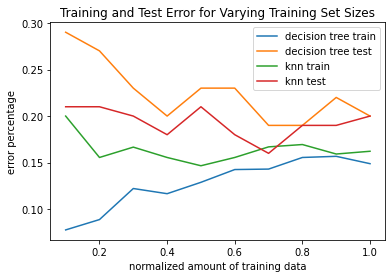

In [770]:

######################################################################
# main
######################################################################

def main():
    
    
    
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/My Drive/schoolwork/3rd_year/winter/cs_m146/hw_1/adult_subsample.csv"
    ### ========== TODO : END ========== ###
    



    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features

    plt.figure()
    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    # plot_histograms (X, y, Xnames=Xnames, yname=yname)
    




    ### ========== TODO : START ========== ###
    scalar = StandardScaler()
    X = scalar.fit_transform(X)
    
    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    major_vote_clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    major_vote_clf.fit(X, y)                  # fit training data using the classifier
    y_pred = major_vote_clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ### --> DONE
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    random_clf = RandomClassifier()
    random_clf.fit(X, y)  
    y_pred = random_clf.predict(X)    
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    tree_clf = DecisionTreeClassifier(criterion='entropy')
    tree_clf.fit(X, y)
    y_pred = tree_clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    ### ========== TODO : END ========== ###






    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')
    
    # for k=3
    k_3_clf = KNeighborsClassifier(n_neighbors=3)
    k_3_clf.fit(X, y)
    y_pred = k_3_clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error for k=3: %.3f' % train_error)

    # for k=5
    k_5_clf = KNeighborsClassifier(n_neighbors=5)
    k_5_clf.fit(X, y)
    y_pred = k_5_clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error for k=5: %.3f' % train_error)

    # for k=7
    k_7_clf = KNeighborsClassifier(n_neighbors=7)
    k_7_clf.fit(X, y)
    y_pred = k_7_clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error for k=7: %.3f' % train_error)
    
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    # for majority vote
    clf = MajorityVoteClassifier()
    train_error, test_error, f1_error = error(clf, X, y)
    print('\t-- training error, test error, F1 error for majority vote: %.3f, %.3f, %.3f' \
          % (train_error, test_error, f1_error))
    
    # for random classifier
    clf = RandomClassifier()
    train_error, test_error, f1_error = error(clf, X, y)
    print('\t-- training error, test error, F1 error for random classifier: %.3f, %.3f, %.3f' \
          % (train_error, test_error, f1_error))
    
    # for decision tree classifier
    clf = DecisionTreeClassifier(criterion='entropy')
    train_error, test_error, f1_error = error(clf, X, y)
    print('\t-- training error, test error, F1 error for decision tree: %.3f, %.3f, %.3f' \
          % (train_error, test_error, f1_error))
    
    # for KNN
    clf = KNeighborsClassifier(n_neighbors=5)
    train_error, test_error, f1_error = error(clf, X, y)
    print('\t-- training error, test error, F1 error for KNN with k=5: %.3f, %.3f, %.3f' \
          % (train_error, test_error, f1_error))
    
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')

    k_list = []
    error_list = []
    
    for i in range(1, 50):
      if i%2 != 1:
        continue

      temp_clf = KNeighborsClassifier(i)
      cross_val_array = cross_val_score(temp_clf, X, y, cv=10)
      k_list.append(i)
      error_list.append(1-np.average(cross_val_array))

    # best val of k is the one that minimizes cross-val error
    min_error = min(error_list)
    best_k = k_list[error_list.index(min_error)]
    print('best value of k is k=%d with 10-fold CV average score of %.3f' \
          % (best_k, min_error))
    
    # plot results
    # plt.figure(figsize = (10,7))
    # plt.xlabel('k value')
    # plt.ylabel('10-fold CV error')
    # plt.plot(k_list, error_list)
    # plt.title('Average Validation Error from 10-fold CV on KNN Model')
    # plt.savefig('/content/drive/My Drive/schoolwork/3rd_year/winter/cs_m146/hw_1/partf.png')


    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')


    train_error = []
    test_error = []
    depth_options = []

    for i in range(1, 21):
      depth_options.append(i)
      clf = DecisionTreeClassifier(criterion='entropy', max_depth=i)
      train_e, test_e, nil = error(clf, X, y, test_size=0.1)
      train_error.append(train_e)
      test_error.append(test_e)

    # make plot
    # plt.plot(depth_options, train_error, depth_options, test_error)
    # plt.xlabel('max depth')
    # plt.ylabel('error percentage')
    # plt.title('Decision Tree Average Training and Test Errors vs Max Depth')
    # plt.legend(['average training error', 'average testing error'])
    # plt.savefig('/content/drive/My Drive/schoolwork/3rd_year/winter/cs_m146/hw_1/partg.png')

    # find best depth limit
    best_depth = depth_options[test_error.index(min(test_error))]
    print("best_depth = %d" % best_depth)






    # for i in range(1, 21):
    #   clf = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    #   training_error, test_error = error(clf, X, y)
    

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    
    tree_train_error = []
    tree_test_error = []
    knn_train_error = []
    knn_test_error = []

    # random 90 10 split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

    percentage_training_data = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    for percentage in percentage_training_data:
      
      tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5)
      knn_clf = KNeighborsClassifier(n_neighbors=15)

      # another split
      if percentage < 1:
        x_train_sub, nil, y_train_sub, nil2 = train_test_split(x_train, y_train, \
                                                                              test_size=1-percentage, random_state=i*10)
      else:
        x_train_sub = x_train
        y_train_sub = y_train

      # fit models
      tree_clf.fit(x_train_sub, y_train_sub)
      knn_clf.fit(x_train_sub, y_train_sub)

      # get training errors
      y_pred = tree_clf.predict(x_train_sub)
      tree_train_error.append(1 - metrics.accuracy_score(y_train_sub, y_pred, normalize=True))
      y_pred = knn_clf.predict(x_train_sub)
      knn_train_error.append(1 - metrics.accuracy_score(y_train_sub, y_pred, normalize=True))

      # get test errors
      y_pred = tree_clf.predict(x_test)
      tree_test_error.append(1 - metrics.accuracy_score(y_test, y_pred, normalize=True))
      y_pred = knn_clf.predict(x_test)
      knn_test_error.append(1 - metrics.accuracy_score(y_test, y_pred, normalize=True))

    # # generate graph
    # plt.plot(percentage_training_data, tree_train_error, percentage_training_data, tree_test_error, \
    #          percentage_training_data, knn_train_error, percentage_training_data, knn_test_error)
    # plt.xlabel('normalized amount of training data')
    # plt.ylabel('error percentage')
    # plt.title('Training and Test Error for Varying Training Set Sizes')
    # plt.legend(['decision tree train', 'decision tree test', 'knn train', 'knn test'])
    # plt.savefig('/content/drive/My Drive/schoolwork/3rd_year/winter/cs_m146/hw_1/parth.png')



    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
